In [1]:
# Notebook: Expression Analysis [including PARP9 gene]
# Description: Notebook contains analysis of genes expresion for covid-19 and non-covid-19 patients
# Data collected from: GSE157103

In [2]:
%load_ext lab_black

In [3]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
import pandas as pd

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
import plotly.express as px
import scipy.stats as sts
import seaborn as sns

from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
import numpy as np

from IPython.display import display
from src.utils import EPIC
import scipy.stats as sts

In [4]:
# Load EPIC manifest

In [5]:
epic = pd.read_csv(
    "../data/Additional/EPIC/MethylationEPIC_v-1-0_B4.csv",
    index_col=0,
    low_memory=False,
)

In [6]:
# Load genes containing DMPs in TSS [cov vs non-cov study]

dmg = pd.read_csv("../Files/DMGenesCoVvsNoNCoV.csv", index_col=0)

dmg = EPIC.extract_probes_in_specific_region(
    dmg, regions_to_extract=["TSS1500", "TSS200"]
)
dmg = dmg.to_frame()

# Add PARP9 (the same probes as DTX3L)
parp9_probes = dmg[dmg["UCSC_RefGene_Name"] == "DTX3L"].copy(deep=True)
parp9_probes["UCSC_RefGene_Name"] = "PARP9"
dmg = pd.concat((dmg, parp9_probes))

display(dmg)
genes_set = set(dmg.UCSC_RefGene_Name.unique())

print(f"DMPs: {len(set(dmg.index))}")
print(f"Genes: {dmg.UCSC_RefGene_Name.nunique()}")

,UCSC_RefGene_Name
cg15528722,TTC33
cg24678928,DDX60
cg03607951,IFI44L
cg07815522,DTX3L
cg24103563,TRIM34
cg13304609,IFI44L
cg15452182,LOC101928650
cg17515347,AIM2
cg07863524,OR3A4
cg01036958,LOC101928650


DMPs: 26
Genes: 20


In [7]:
# Load expression data

In [8]:
raw_ttable = pd.read_table("../Expression/GSE157103_genes.tpm.tsv", index_col=0).T
raw_ttable

#symbol,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
C1,0.49,0.00,0.21,0.04,0.07,0.0,0.03,18.92,4.07,0.0,...,2.84,4.22,0.95,1.63,15.51,0.06,8.17,363.01,19.17,6.05
C2,0.29,0.00,0.14,0.00,0.00,0.0,0.05,18.68,3.00,0.0,...,3.55,12.15,0.60,1.15,15.62,0.14,8.20,399.80,15.72,4.12
C3,0.26,0.00,0.03,0.02,0.00,0.0,0.07,13.85,1.83,0.0,...,1.34,2.79,0.18,0.32,17.67,0.28,3.62,430.35,13.95,1.81
C4,0.45,0.01,0.09,0.07,0.00,0.0,0.00,22.11,4.22,0.0,...,3.71,5.87,1.40,2.21,15.61,0.27,7.88,209.25,14.78,7.15
C5,0.17,0.00,0.00,0.05,0.07,0.0,0.00,8.45,1.17,0.0,...,1.44,4.46,0.28,0.55,9.34,0.07,5.96,272.91,8.69,2.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NC22,0.30,0.00,0.02,0.02,0.00,0.0,0.00,17.06,1.96,0.0,...,0.26,1.01,0.13,0.46,5.93,0.24,1.58,447.14,3.04,1.00
NC23,0.70,0.00,0.02,0.01,0.00,0.0,0.00,20.31,1.54,0.0,...,0.64,0.83,0.18,0.73,8.75,0.12,1.57,748.55,4.55,1.56
NC24,0.75,0.00,0.27,0.00,0.06,0.0,0.00,27.25,3.42,0.0,...,1.18,2.14,0.41,1.29,14.93,0.14,5.05,437.62,10.34,3.99
NC25,2.80,0.00,0.04,0.00,0.00,0.0,0.00,21.64,1.43,0.0,...,0.42,0.61,0.19,0.45,4.77,0.33,1.07,369.66,1.83,0.96


In [9]:
# Drop genes with average expression value < 1

raw_ttable = raw_ttable.loc[:, raw_ttable.mean().round(0) > 1]
raw_ttable.shape

(126, 10249)

In [10]:
# Select differential methylated genes

In [11]:
ttable = raw_ttable[genes_set.intersection(set(raw_ttable.columns))]

genes_set = set(ttable.columns)  # Update genes
print("Updated number of genes: ", len(genes_set))

# Add information about patient status
ttable["TYPE"] = [
    "COVID-19 USA" if name.startswith("C") else "non-COVID-19 USA"
    for name in raw_ttable.index
]  # Add TYPE column with disease status

ttable

Updated number of genes:  13


<ipython-input-11-6c8607d41f38>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ttable["TYPE"] = [


#symbol,TRA2B,RSAD2,AIM2,PGBD3,TTC33,DTX3L,DDX60,CRNKL1,PARP9,TRIM22,MX1,TRIM34,IFI44L,TYPE
C1,33.01,812.32,102.60,1.40,6.41,145.23,115.76,19.21,402.93,878.28,968.53,52.94,470.26,COVID-19 USA
C2,40.79,28.71,36.29,1.60,5.82,39.90,15.15,15.67,112.39,236.38,53.01,24.57,10.81,COVID-19 USA
C3,16.20,797.39,157.94,1.85,3.44,122.19,105.36,18.24,431.47,802.34,861.15,34.64,355.75,COVID-19 USA
C4,49.26,20.48,16.85,2.43,6.32,40.19,13.57,21.55,100.88,224.91,101.72,29.81,17.33,COVID-19 USA
C5,26.13,168.49,279.70,1.63,5.72,95.64,43.04,19.54,398.58,1086.22,59.63,35.90,44.53,COVID-19 USA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NC22,17.96,1.38,5.84,0.74,1.06,7.99,1.07,6.00,13.07,24.43,11.96,5.28,1.19,non-COVID-19 USA
NC23,19.59,45.93,61.93,0.84,1.36,23.73,9.00,10.02,82.05,134.13,117.19,14.21,15.65,non-COVID-19 USA
NC24,40.09,7.30,15.15,2.60,3.78,24.23,5.33,14.85,62.55,86.22,48.53,19.71,4.96,non-COVID-19 USA
NC25,16.58,50.27,4.67,0.64,0.86,14.29,2.72,9.21,15.18,35.02,101.83,5.08,17.61,non-COVID-19 USA


In [12]:
# Perform Ward clustering on selected genes

<Figure size 936x936 with 0 Axes>

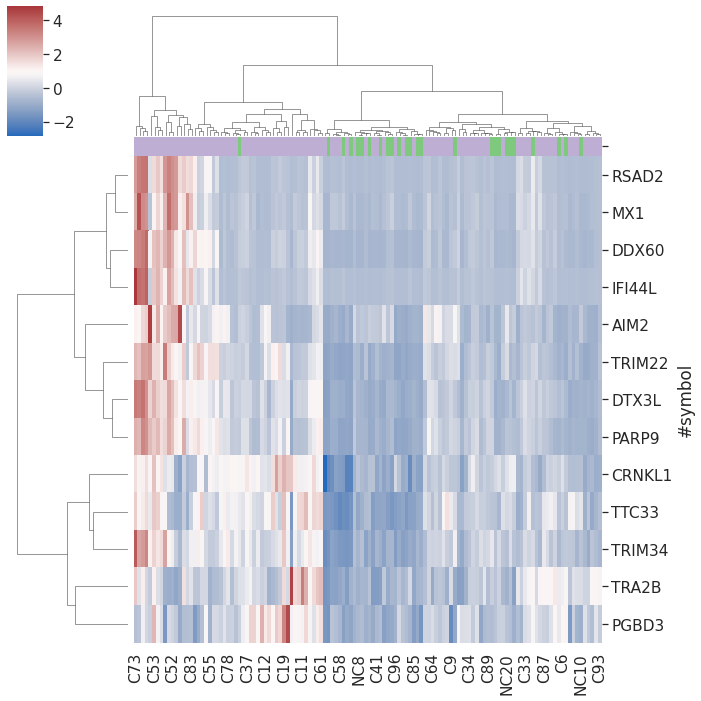

In [13]:
# Create palette for samples group
pal = sns.color_palette("Accent", ttable["TYPE"].nunique())
lut = dict(zip(map(str, ttable["TYPE"].unique()[::-1]), pal))
colors = ttable["TYPE"].map(lut)
colors.name = ""

# Set fig details
sns.set(font_scale=1.4)
plt.figure(figsize=(13, 13))

# Remove status from expression data
df_ttable = ttable.drop("TYPE", axis=1)

cols = df_ttable.columns
idx = df_ttable.index

# Scale expresion data
df_ttable = StandardScaler().fit_transform(df_ttable)
df_ttable = pd.DataFrame(df_ttable, index=idx, columns=cols).T

# Visualisation
fig = sns.clustermap(df_ttable, method="ward", col_colors=colors, cmap="vlag")
fig.savefig("../Plots/ClusterMapsExpression/CLS_expression_with_PARP9.jpg")
plt.show()

In [14]:
# DEG - differential expressed genes

In [15]:
cf = pd.read_csv(
    "../data/processed/CF/USA_before_CFC.csv", index_col=0
)  # -> Estimated WBC fractions for each sample using RPC method from EpiDish package

sample_names = dict(
    pd.read_csv("../data/raw/CONCATED_USA_HB/SampleSheet.csv", index_col=0)["ID"]
)

cf.index = [
    sample_names.get(name) if name in sample_names.keys() else name for name in cf.index
]  # Convert GSE number to C if covid sample and NC in non covid samples

ins = set.intersection(
    set(ttable.index), set(cf.index)
)  # select overlapping samples for methylation data [predicted WBC fractions] and expression data

# Get overlapping samples
cf = cf.loc[ins]
ttable = ttable.loc[ins]

display(cf)

cf.drop("Eosino", axis=1, inplace=True)  # Drop Eosino fraction due to low abudance

,B,NK,CD4T,CD8T,Mono,Neutro,Eosino
C75,0.000000,0.030621,0.000000,0.000000,0.098956,0.870423,0.0
NC18,0.000000,0.000000,0.000000,0.001006,0.081722,0.917272,0.0
C30,0.024060,0.013083,0.013061,0.001944,0.053960,0.893892,0.0
C83,0.000000,0.131001,0.000000,0.024962,0.112115,0.731922,0.0
C50,0.072993,0.046411,0.052765,0.011655,0.127200,0.688977,0.0
...,...,...,...,...,...,...,...
C29,0.000000,0.000000,0.000000,0.000000,0.041720,0.958280,0.0
C45,0.000000,0.000000,0.000000,0.000000,0.048777,0.951223,0.0
C64,0.000000,0.000000,0.000000,0.000000,0.029397,0.970603,0.0
C101,0.029706,0.000000,0.164752,0.000000,0.095767,0.709774,0.0


In [16]:
def calculate_vif(df: pd.DataFrame) -> pd.DataFrame:
    vif = pd.DataFrame()
    vif["variables"] = cf.columns
    vif["VIF"] = [variance_inflation_factor(cf.values, i) for i in range(cf.shape[1])]

    return vif

In [17]:
# VIF
calculate_vif(cf)

,variables,VIF
0,B,1.577807
1,NK,1.873270
2,CD4T,2.479004
3,CD8T,1.973055
4,Mono,6.008261
5,Neutro,4.314576


In [18]:
cf = cf.drop("Neutro", axis=1)
calculate_vif(cf)

,variables,VIF
0,B,1.572463
1,NK,1.803158
2,CD4T,2.357481
3,CD8T,1.939683
4,Mono,1.916001


In [19]:
clinical = pd.read_excel(
    "../data/Additional/13148_2021_1102_MOESM1_ESM.xlsx", skiprows=1, index_col=1
)  # Load clinical

model_variables = pd.concat(
    (cf, clinical[["Sex", "Age", "ICU (1=yes)", "Covid (1=yes)"]]), axis=1
).dropna()
# concate clinical data with WBC fractions

model_variables["Sex"] = model_variables["Sex"].map(
    {"M": 1, "F": 0}
)  # Convert sex to int
model_variables

,B,NK,CD4T,CD8T,Mono,Sex,Age,ICU (1=yes),Covid (1=yes)
C75,0.000000,0.030621,0.000000,0.000000,0.098956,1,55,0,1
NC18,0.000000,0.000000,0.000000,0.001006,0.081722,1,88,1,0
C30,0.024060,0.013083,0.013061,0.001944,0.053960,1,54,1,1
C83,0.000000,0.131001,0.000000,0.024962,0.112115,0,85,0,1
C50,0.072993,0.046411,0.052765,0.011655,0.127200,1,37,1,1
...,...,...,...,...,...,...,...,...,...
C29,0.000000,0.000000,0.000000,0.000000,0.041720,0,63,1,1
C45,0.000000,0.000000,0.000000,0.000000,0.048777,0,62,1,1
C64,0.000000,0.000000,0.000000,0.000000,0.029397,1,65,1,1
C101,0.029706,0.000000,0.164752,0.000000,0.095767,1,58,1,1


In [20]:
# perform differential expression analysis

Optimization terminated successfully.
         Current function value: 0.411089
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:          Covid (1=yes)   No. Observations:                  125
Model:                          Logit   Df Residuals:                      115
Method:                           MLE   Df Model:                            9
Date:                Fri, 10 Sep 2021   Pseudo R-squ.:                  0.1960
Time:                        18:01:40   Log-Likelihood:                -51.386
converged:                       True   LL-Null:                       -63.912
Covariance Type:            nonrobust   LLR p-value:                  0.002915
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.9862      1.693      1.173      0.241      -1.333       5.305
TRA2B           0.0841    

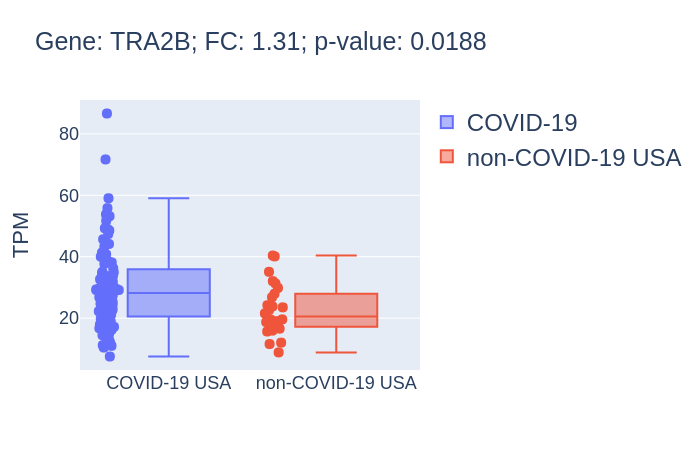

Optimization terminated successfully.
         Current function value: 0.396390
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:          Covid (1=yes)   No. Observations:                  125
Model:                          Logit   Df Residuals:                      115
Method:                           MLE   Df Model:                            9
Date:                Fri, 10 Sep 2021   Pseudo R-squ.:                  0.2247
Time:                        18:01:44   Log-Likelihood:                -49.549
converged:                       True   LL-Null:                       -63.912
Covariance Type:            nonrobust   LLR p-value:                 0.0007207
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.9457      1.622      1.816      0.069      -0.233       6.125
RSAD2           0.0135    

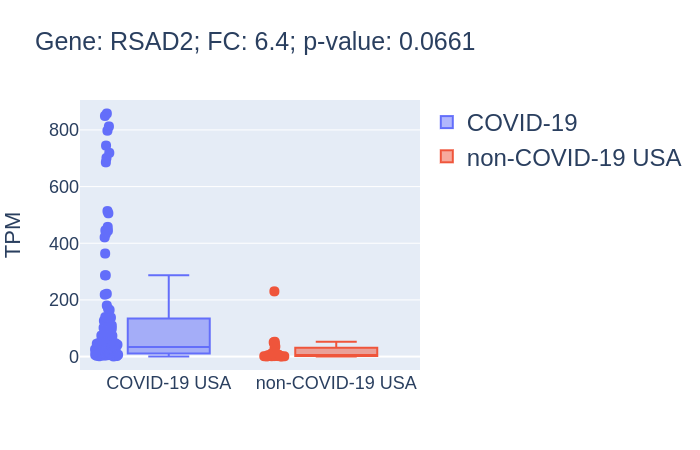

Optimization terminated successfully.
         Current function value: 0.406400
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:          Covid (1=yes)   No. Observations:                  125
Model:                          Logit   Df Residuals:                      115
Method:                           MLE   Df Model:                            9
Date:                Fri, 10 Sep 2021   Pseudo R-squ.:                  0.2052
Time:                        18:01:45   Log-Likelihood:                -50.800
converged:                       True   LL-Null:                       -63.912
Covariance Type:            nonrobust   LLR p-value:                  0.001878
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.1596      1.661      1.300      0.193      -1.096       5.415
AIM2            0.0230    

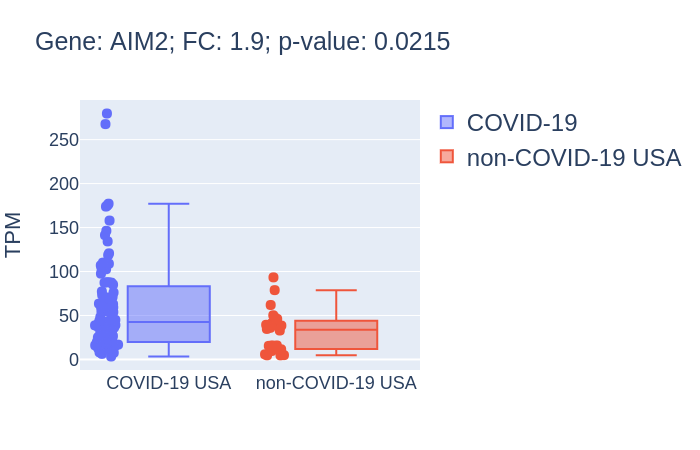

Optimization terminated successfully.
         Current function value: 0.397677
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:          Covid (1=yes)   No. Observations:                  125
Model:                          Logit   Df Residuals:                      115
Method:                           MLE   Df Model:                            9
Date:                Fri, 10 Sep 2021   Pseudo R-squ.:                  0.2222
Time:                        18:01:45   Log-Likelihood:                -49.710
converged:                       True   LL-Null:                       -63.912
Covariance Type:            nonrobust   LLR p-value:                 0.0008162
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.4085      1.659      0.849      0.396      -1.842       4.659
PGBD3           1.2933    

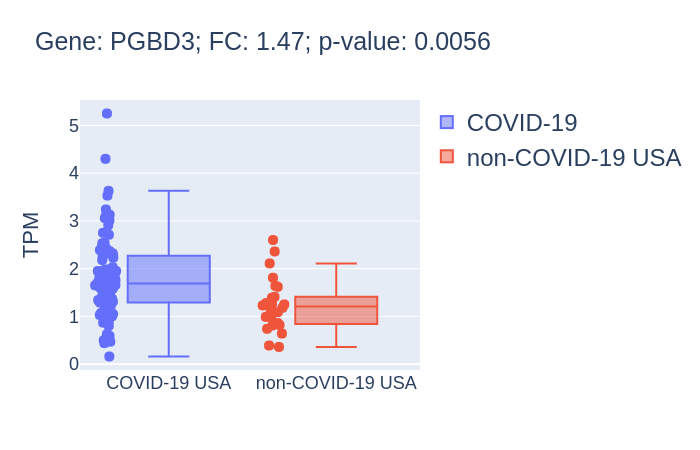

Optimization terminated successfully.
         Current function value: 0.377771
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:          Covid (1=yes)   No. Observations:                  125
Model:                          Logit   Df Residuals:                      115
Method:                           MLE   Df Model:                            9
Date:                Fri, 10 Sep 2021   Pseudo R-squ.:                  0.2611
Time:                        18:01:45   Log-Likelihood:                -47.221
converged:                       True   LL-Null:                       -63.912
Covariance Type:            nonrobust   LLR p-value:                 0.0001146
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.2158      1.697      0.716      0.474      -2.111       4.542
TTC33           0.5630    

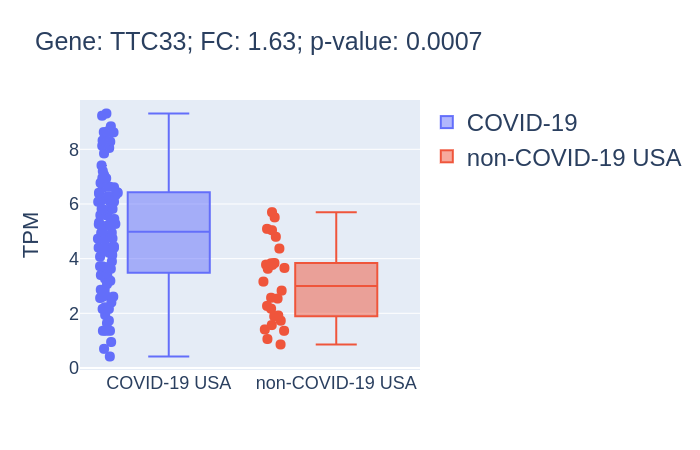

Optimization terminated successfully.
         Current function value: 0.384894
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:          Covid (1=yes)   No. Observations:                  125
Model:                          Logit   Df Residuals:                      115
Method:                           MLE   Df Model:                            9
Date:                Fri, 10 Sep 2021   Pseudo R-squ.:                  0.2472
Time:                        18:01:45   Log-Likelihood:                -48.112
converged:                       True   LL-Null:                       -63.912
Covariance Type:            nonrobust   LLR p-value:                 0.0002334
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.6860      1.623      1.655      0.098      -0.496       5.868
IFI44L          0.0466   

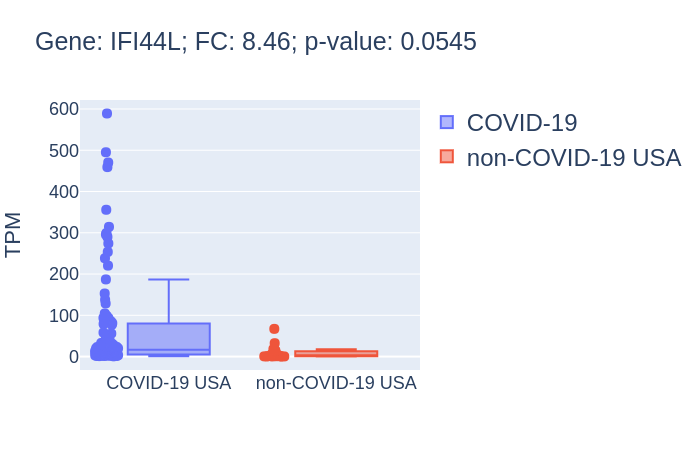

Optimization terminated successfully.
         Current function value: 0.342471
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:          Covid (1=yes)   No. Observations:                  125
Model:                          Logit   Df Residuals:                      115
Method:                           MLE   Df Model:                            9
Date:                Fri, 10 Sep 2021   Pseudo R-squ.:                  0.3302
Time:                        18:01:45   Log-Likelihood:                -42.809
converged:                       True   LL-Null:                       -63.912
Covariance Type:            nonrobust   LLR p-value:                 3.014e-06
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.6318      1.833      0.345      0.730      -2.962       4.225
DTX3L           0.0863    

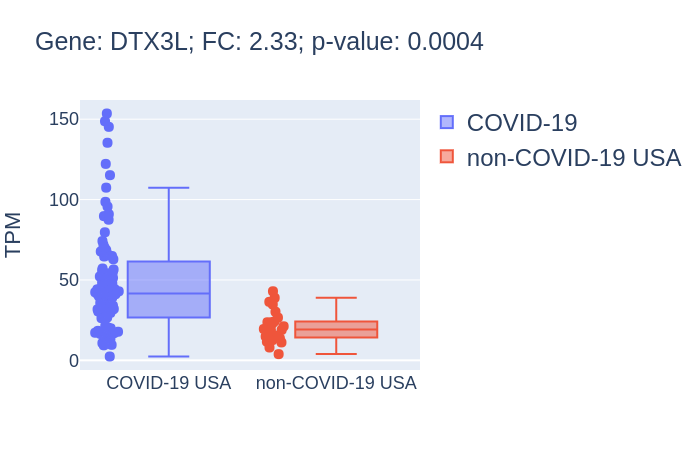

Optimization terminated successfully.
         Current function value: 0.373741
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:          Covid (1=yes)   No. Observations:                  125
Model:                          Logit   Df Residuals:                      115
Method:                           MLE   Df Model:                            9
Date:                Fri, 10 Sep 2021   Pseudo R-squ.:                  0.2690
Time:                        18:01:45   Log-Likelihood:                -46.718
converged:                       True   LL-Null:                       -63.912
Covariance Type:            nonrobust   LLR p-value:                 7.635e-05
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.9892      1.698      1.172      0.241      -1.338       5.316
DDX60           0.1146    

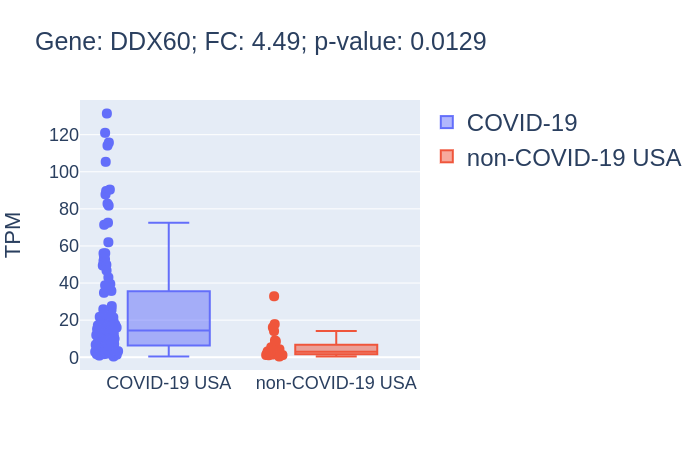

Optimization terminated successfully.
         Current function value: 0.404623
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:          Covid (1=yes)   No. Observations:                  125
Model:                          Logit   Df Residuals:                      115
Method:                           MLE   Df Model:                            9
Date:                Fri, 10 Sep 2021   Pseudo R-squ.:                  0.2086
Time:                        18:01:45   Log-Likelihood:                -50.578
converged:                       True   LL-Null:                       -63.912
Covariance Type:            nonrobust   LLR p-value:                  0.001587
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1545      1.964      0.079      0.937      -3.696       4.004
CRNKL1          0.1903    

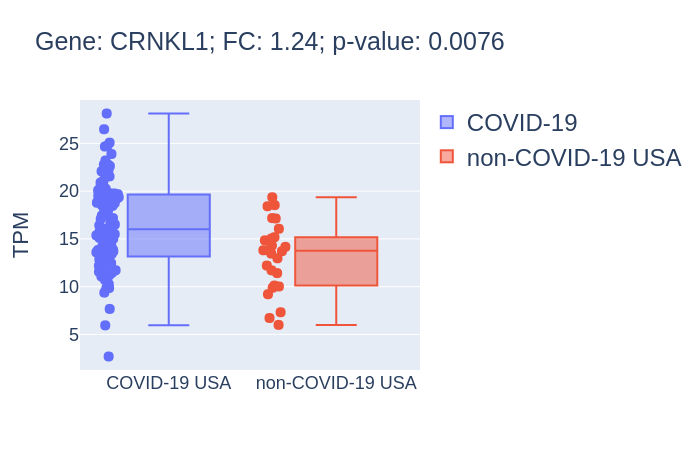

Optimization terminated successfully.
         Current function value: 0.353936
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:          Covid (1=yes)   No. Observations:                  125
Model:                          Logit   Df Residuals:                      115
Method:                           MLE   Df Model:                            9
Date:                Fri, 10 Sep 2021   Pseudo R-squ.:                  0.3078
Time:                        18:01:46   Log-Likelihood:                -44.242
converged:                       True   LL-Null:                       -63.912
Covariance Type:            nonrobust   LLR p-value:                 1.000e-05
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.8727      1.806      0.483      0.629      -2.667       4.412
PARP9           0.0196    

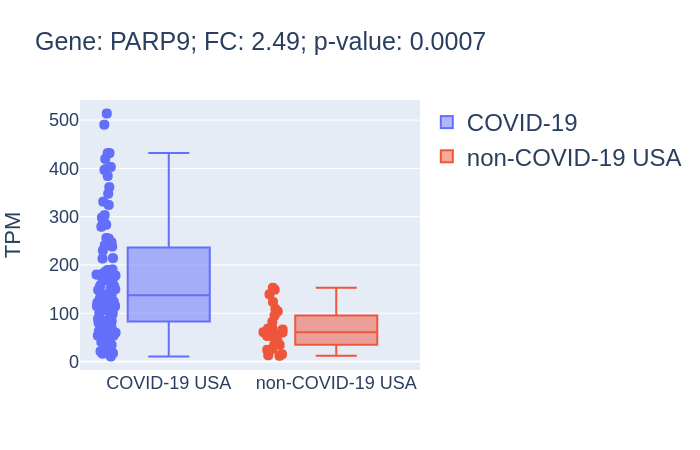

Optimization terminated successfully.
         Current function value: 0.356957
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:          Covid (1=yes)   No. Observations:                  125
Model:                          Logit   Df Residuals:                      115
Method:                           MLE   Df Model:                            9
Date:                Fri, 10 Sep 2021   Pseudo R-squ.:                  0.3019
Time:                        18:01:46   Log-Likelihood:                -44.620
converged:                       True   LL-Null:                       -63.912
Covariance Type:            nonrobust   LLR p-value:                 1.369e-05
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.8843      1.801      0.491      0.623      -2.645       4.413
TRIM22          0.0085    

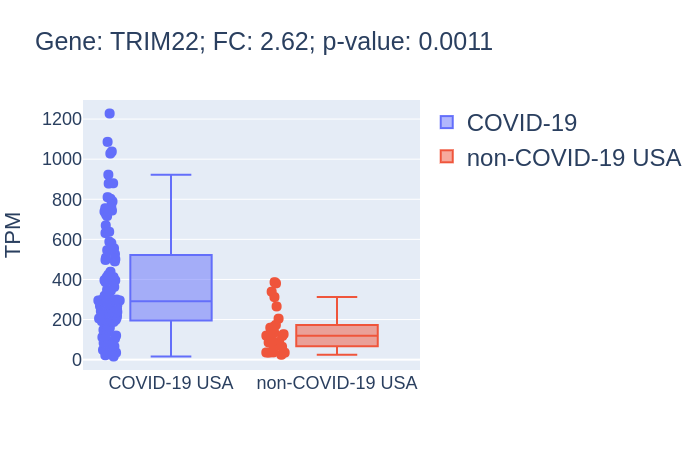

Optimization terminated successfully.
         Current function value: 0.385271
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:          Covid (1=yes)   No. Observations:                  125
Model:                          Logit   Df Residuals:                      115
Method:                           MLE   Df Model:                            9
Date:                Fri, 10 Sep 2021   Pseudo R-squ.:                  0.2465
Time:                        18:01:46   Log-Likelihood:                -48.159
converged:                       True   LL-Null:                       -63.912
Covariance Type:            nonrobust   LLR p-value:                 0.0002423
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.4722      1.654      1.495      0.135      -0.770       5.714
MX1             0.0176    

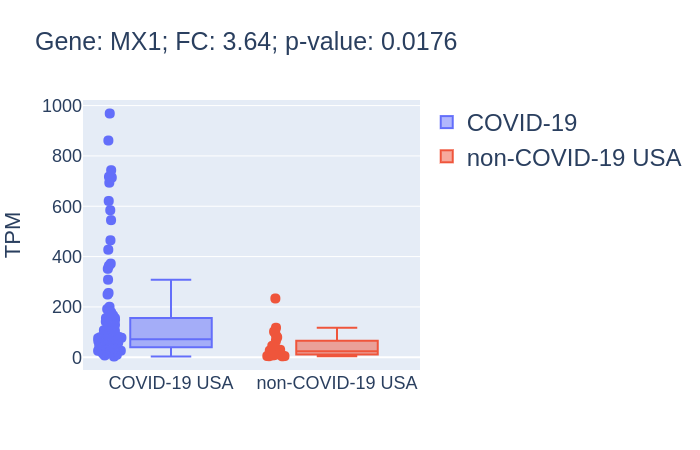

Optimization terminated successfully.
         Current function value: 0.403755
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:          Covid (1=yes)   No. Observations:                  125
Model:                          Logit   Df Residuals:                      115
Method:                           MLE   Df Model:                            9
Date:                Fri, 10 Sep 2021   Pseudo R-squ.:                  0.2103
Time:                        18:01:46   Log-Likelihood:                -50.469
converged:                       True   LL-Null:                       -63.912
Covariance Type:            nonrobust   LLR p-value:                  0.001461
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.9349      1.703      1.136      0.256      -1.403       5.273
TRIM34          0.0857    

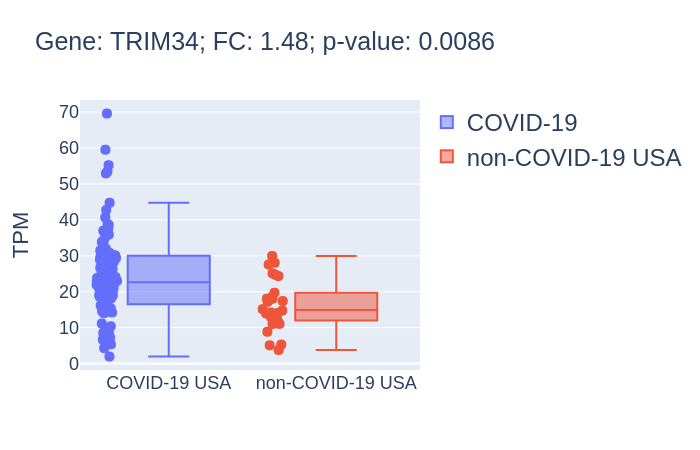

In [21]:
DEG = []

for common_gene in genes_set:

    df = pd.concat(
        (ttable[common_gene], model_variables), axis=1
    ).dropna()  # Merge expression data for specific gene with covariates

    # Fit logit model model: Covid ~ gene expression + WBC + Age + Sex + ICU
    df = sm.add_constant(df)  # Add constant
    df = df.astype(float)

    mod = sm.Logit(
        df["Covid (1=yes)"], df.drop("Covid (1=yes)", axis=1)
    )  # Initialize model
    res = mod.fit()

    # Get Wald pvalues
    pvalues = res.pvalues
    pval = round(pvalues[common_gene], 4)  # pvalue for gene expression variable

    # Get expression data for covid-19 samples
    cov = ttable[ttable["TYPE"] == "COVID-19 USA"][common_gene].values.flatten()

    # Get expression data for non-covid-19 samples
    nocov = ttable[ttable["TYPE"] == "non-COVID-19 USA"][common_gene].values.flatten()

    # Estimate Fold-change
    fc = round(np.mean(cov) / np.mean(nocov), 2)  # Fold change

    # Def: If FC >= 1.5 or FC <= 0.5 and pval for expression level variable in model <= 0.05 gene is DE
    if ((fc >= 1.5) | (fc <= 0.5)) & (pval <= 0.05):
        DEG.append(common_gene)

    # Show model summary
    print(res.summary())

    # Create Plots
    fig = go.Figure()

    # Add covid expression box
    fig.add_trace(
        go.Box(
            x=["COVID-19 USA"] * len(cov),
            y=cov,
            name="COVID-19",
            boxpoints="all",
        )
    )

    # Add non-covid expression box
    fig.add_trace(
        go.Box(
            x=["non-COVID-19 USA"] * len(nocov),
            y=nocov,
            name="non-COVID-19 USA",
            boxpoints="all",
        )
    )

    fig.update_layout(
        title=f"Gene: {common_gene}; FC: {fc}; p-value: {pval}",
        yaxis_title="TPM",
        showlegend=True,
    )

    fig.update_layout(legend=dict(font=dict(size=24), title=""), font=dict(size=18))
    fig.update_traces(marker=dict(size=10))

    fig.show(renderer="png")
    fig.write_image(f"../Plots/ExpressionBoxes/{common_gene}.jpg")

In [23]:
print(f"Number of DEGs: {len(DEG)}")
print(DEG)

pd.DataFrame(DEG).to_csv("../Files/CoVvsNoNCoVDEGs_with_PARP.csv")

Number of DEGs: 8
['AIM2', 'TTC33', 'DTX3L', 'DDX60', 'PARP9', 'TRIM22', 'MX1', 'IFI44L']
